# Modelling

In this last analysis part we will try different ML models to to predict if patient might have a stroke.
We will try variuos ML models like:
- Random forest
- Decision tree
- KNeighbors classifier
- Logistic regresion
- Support Vector classifier
- Gradient Boosting classifier
- XGBoost

We will try default models parameters configuration and parameters after the hyperparameter tunning reveived best model parameters. 

We will compare models quality metrics, the results and will select the best performin model, which predicts most accurately the stoke probability.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
import math

import scipy.stats.distributions as dist
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from generic_functions import value_counts_to_dataframe, pivot_dim2
from modelling_functions import fit_model, kfold_cross_validation

# balancing dataset
from imblearn.over_sampling import SMOTE

from sklearn import model_selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_recall_curve


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline

from scipy.stats import reciprocal, uniform

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S2'

We will use dataset after all data and features preparation

In [43]:
path_file = '/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S2/Output/df_scaled.csv'
df = pd.read_csv(path_file).reset_index()
df = df.rename(columns={'index':'id'})
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5110 non-null   int64  
 1   gender               5110 non-null   float64
 2   hypertension         5110 non-null   float64
 3   heart_disease        5110 non-null   float64
 4   ever_married         5110 non-null   float64
 5   work_type            5110 non-null   float64
 6   Residence_type       5110 non-null   float64
 7   smoking_status       5110 non-null   float64
 8   Age_adj              5110 non-null   float64
 9   AgeGroups            5110 non-null   float64
 10  avg_glucose_level_n  5110 non-null   float64
 11  bmi_n                5110 non-null   float64
 12  stroke               5110 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 519.1 KB


,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,Age_adj,AgeGroups,avg_glucose_level_n,bmi_n,stroke
0,0,1.188073,-0.328602,4.185032,0.723884,-0.153836,0.984080,-0.351781,1.052296,1.993905,2.706375,1.005086,1
1,1,-0.840344,-0.328602,-0.238947,0.723884,0.763438,-1.016178,0.581552,0.786485,-0.501528,2.121559,-0.098981,1
2,2,1.188073,-0.328602,4.185032,0.723884,-0.153836,-1.016178,0.581552,1.628221,1.993905,-0.005028,0.472536,1


# Baseline

For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the positive ('stroke'), I will take the inverse of that. In other words, always predicting the most common outcome.

For this case, 249/(249+4861) = 0.048

So a good target to beat would be 5%~ for recall for positive stroke patients.

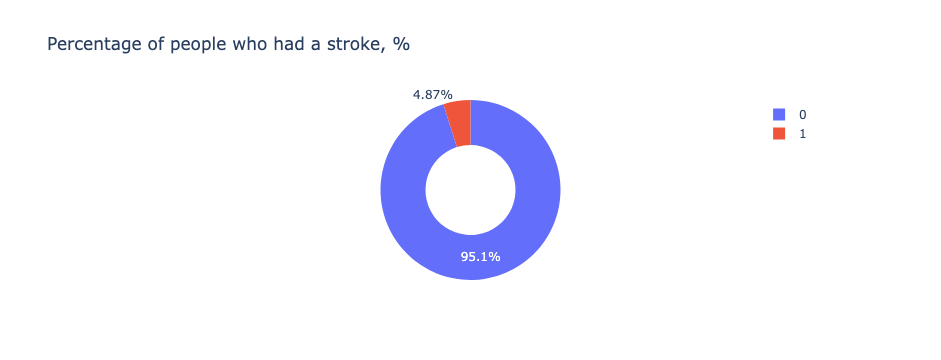

In [44]:
attrib = 'stroke'
temp_df = value_counts_to_dataframe(df,attrib)

fig = px.pie(temp_df, values='counts', 
       names='stroke', 
       hole=.5,
       title=f'Percentage of people who had a {attrib}, %')
fig.show()

In [45]:
# Inverse of Null Accuracy
print('Inverse of Null Accuracy: ',df[df.stroke == 1].id.count()/len(df))
print('Null Accuracy: ',df[df.stroke != 1].id.count()/len(df))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


Let's select feature and target columns from dataset

In [46]:
features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
           'work_type', 'Residence_type', 'smoking_status',  
            'Age_adj', 'AgeGroups', 'avg_glucose_level_n', 'bmi_n']

target = ['stroke']

# Oversampling the imbalanced datasets - SMOTE

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [47]:
X , y = df[features],df[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

sm = SMOTE()

X_res, y_res = sm.fit_resample(x_train,y_train)

print("Before OverSampling, counts of label '1': {}".format((y==1).sum()[0]))
print("Before OverSampling, counts of label '0': {} \n".format((y==0).sum()[0]))

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format((y_res==1).sum()[0]))
print("After OverSampling, counts of label '0': {}".format((y_res==1).sum()[0]))

Before OverSampling, counts of label '1': 249
Before OverSampling, counts of label '0': 4861 

After OverSampling, the shape of train_X: (7802, 11)
After OverSampling, the shape of train_y: (7802, 1) 

After OverSampling, counts of label '1': 3901
After OverSampling, counts of label '0': 3901


In [48]:
usampled_eval_df = X_res.assign(stroke = y_res)
usampled_eval_df.head(5)

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,Age_adj,AgeGroups,avg_glucose_level_n,bmi_n,stroke
0,1.188073,-0.328602,-0.238947,0.723884,0.763438,-1.016178,-0.351781,1.583919,1.993905,0.143384,-0.047025,0
1,-0.840344,-0.328602,-0.238947,0.723884,-0.153836,0.984080,-1.285114,0.830787,-0.501528,-0.393728,0.966119,0
2,-0.840344,-0.328602,-0.238947,-1.381436,-0.153836,-1.016178,0.581552,-0.985592,-0.501528,-1.029783,0.628404,0
3,1.188073,-0.328602,-0.238947,0.723884,-1.988384,0.984080,-0.351781,-0.542573,-0.501528,-0.893296,0.199767,0
4,-0.840344,-0.328602,-0.238947,-1.381436,-0.153836,-1.016178,0.581552,-0.542573,-0.501528,-1.027354,-1.164081,0


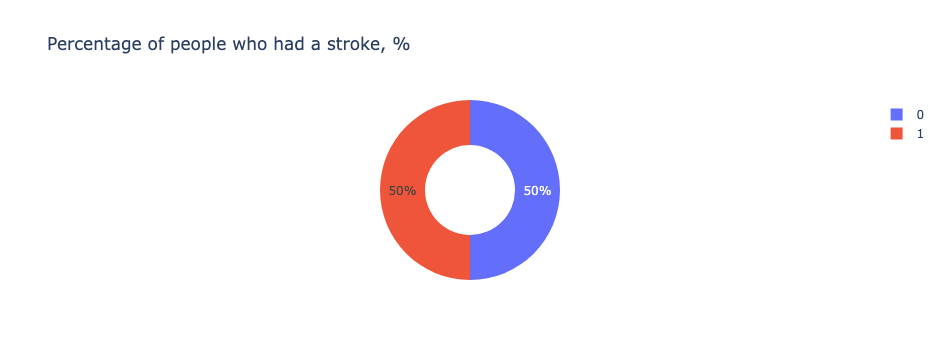

In [49]:
attrib = 'stroke'
temp_df = value_counts_to_dataframe(usampled_eval_df,attrib)

fig = px.pie(temp_df, values='counts', 
       names='stroke', 
       hole=.5,
       title=f'Percentage of people who had a {attrib}, %')
fig.show()

Now we have an upsampled version of our dataset where both sample outcomes are uniformly distributed. The models we will try to train might have a better chance of picking up on the details that define stroke individuals from those who are negative for a stroke.

# Modelling

In [50]:
def fit_model(model_name,classifier,x_train,y_train,x_test,y_test):
    """Fit and predict model"""
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    
    """Plot Roc Auc grap for the model quality checking"""
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name='example estimator')
    display.plot()
    plt.show()  
    
    """Creates the confusion matrix"""
    cm = confusion_matrix(y_test, prediction)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    """Saving model quality metrics results into the dictionary to use them later
    in models quality performance comparison part"""
    model_eval = {'model_name': model_name,
                  'acc': accuracy_score(prediction, y_test)*100,
                  'precision': precision_score(y_test, prediction, average='macro')*100,
                  'recall': recall_score(y_test, prediction, average='macro')*100,
                  'f1': f1_score(y_test, prediction, average='macro')*100
                 }
    
    return  model_eval

    
def kfold_cross_validation(model_name,classifier,X):    
    """Cross validation using KFold method"""
    folds = KFold(n_splits=5)
    folds.get_n_splits(X)
    fold = 0
    acc_f = []
    acc_cv = []
    for train_index, test_index in folds.split(X):
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

        model = classifier
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        fold = fold +1
        # clear_output()
        acc_ = accuracy_score(y_pred_cv, y_test_cv)
        acc_cv.append(acc_)
        acc_f_ = {f"acc_in_fold_{fold}": acc_ }
        acc_f.append(acc_f_)

    
    print(*acc_f, sep = "\n")
    print("Cross Validation Score : ",'{0:.2%}'.format(sum(acc_cv) / len(acc_cv) ))

We assigned features and target arrays and split upsampled dataset into train and test samples

In [51]:
X, y = usampled_eval_df[features],usampled_eval_df[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(x_train), len(x_test)

(6241, 1561)

Let's collect each model quality performance results into the dataframe.
We will start with the baseline results saving, first.

In [52]:
res_df = pd.DataFrame()

baseline = {'model_name': 'Baseline',
          'acc': 95.13720156555773,
          'precision': 95.13720156555773,
          'recall': 95.13720156555773,
          'f1': 95.13720156555773
        }
res_df = res_df.append(pd.DataFrame.from_dict(baseline,orient='index').T)
res_df

,model_name,acc,precision,recall,f1
0,Baseline,95.137202,95.137202,95.137202,95.137202


## Random forest

ROC_AUC Score :  96.92%


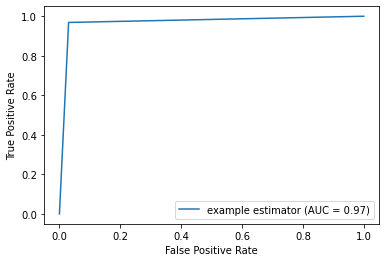

{'acc_in_fold_1': 0.9442664958360025}
{'acc_in_fold_2': 0.9282511210762332}
{'acc_in_fold_3': 0.9666666666666667}
{'acc_in_fold_4': 0.9891025641025641}
{'acc_in_fold_5': 0.9762820512820513}
Cross Validation Score :  96.09%


{'model_name': 'Random Forest',
 'acc': 96.92504804612429,
 'precision': 96.92398640327109,
 'recall': 96.92398640327109,
 'f1': 96.92398640327109}

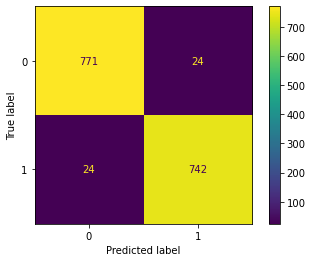

In [53]:
rf = RandomForestClassifier()

res = fit_model('Random Forest',rf,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Random Forest',rf,X)
res

The default parameters model gave quite good results, where accurasy is 96.925% and f1 is 96.923%.
The confusion matrix also presents how well true positive and true negative model distributes the patients.

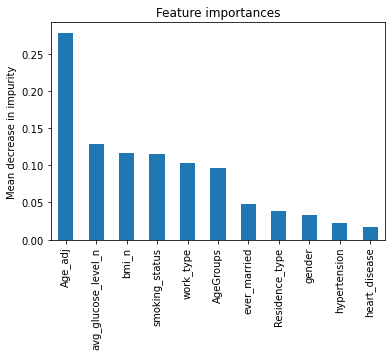

In [54]:
feature_importances = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

The most weight in the model had age feature. It confirms the EDA resutls and hypothesis that older patients have higher probability to have stroke. 

In later significant place are avg. glucose level, bmi, smoking status, work type. 
We saw the distributions differences among these attributes, too.

#### Hyperparameter Tuning

Lets try various combinations of parameters with Random forest model and check if they can give better model quality performance.

In [23]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'criterion' : ['gini', 'entropy'],
    'n_estimators': [100, 200, 300, 1000]
}

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid,n_jobs=-1)
grid.fit(x_train,np.ravel(y_train))

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [80, 90, 100, 110, 120],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]})

After the Grid Search CV technique the best performing model paramters configuration is:

In [55]:
grid.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 120,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

ROC_AUC Score :  95.79%


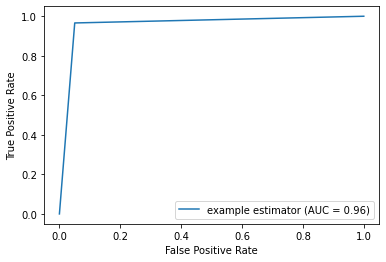

{'acc_in_fold_1': 0.9154388212684177}
{'acc_in_fold_2': 0.9141575912876362}
{'acc_in_fold_3': 0.9544871794871795}
{'acc_in_fold_4': 0.9782051282051282}
{'acc_in_fold_5': 0.9634615384615385}
Cross Validation Score :  94.52%


{'model_name': 'Random Forest HT',
 'acc': 95.77194106342088,
 'precision': 95.7713647854493,
 'recall': 95.78714879222294,
 'f1': 95.77155062023496}

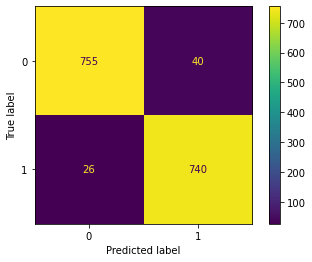

In [56]:
rfc = RandomForestClassifier(n_estimators=200,criterion='entropy',max_features=3,max_depth=120,bootstrap=True,
                            min_samples_leaf=3,min_samples_split=8)

res = fit_model('Random Forest HT',rfc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Random Forest HT',rfc,X)
res

Unfortunately, this combination haven't increased accurasy and f1 score as expected.

Let's reduce number of parameters and check the model results, then:

ROC_AUC Score :  96.73%


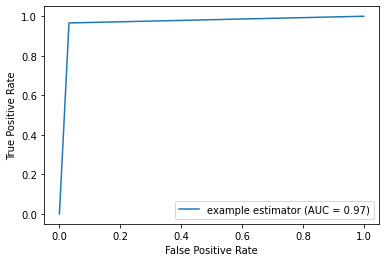

{'acc_in_fold_1': 0.9461883408071748}
{'acc_in_fold_2': 0.9391415759128764}
{'acc_in_fold_3': 0.967948717948718}
{'acc_in_fold_4': 0.9891025641025641}
{'acc_in_fold_5': 0.9743589743589743}
Cross Validation Score :  96.33%


{'model_name': 'Random Forest other',
 'acc': 96.73286354900704,
 'precision': 96.7328472427497,
 'recall': 96.73054501863803,
 'f1': 96.7316563901863}

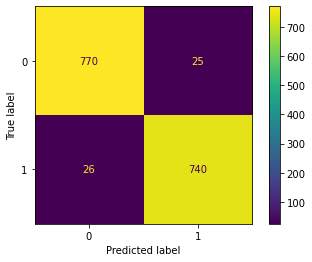

In [59]:
rfc = RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth=120,bootstrap=True)

res = fit_model('Random Forest other',rfc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Random Forest other',rfc,X)
res

It is better than baseline and model with more adjusted parameters. But default model parameters configuration still performs better.

## Decision Tree

The same approach we will try with the rest ML models and will capture the quality metrics to compare them later

ROC_AUC Score :  93.34%


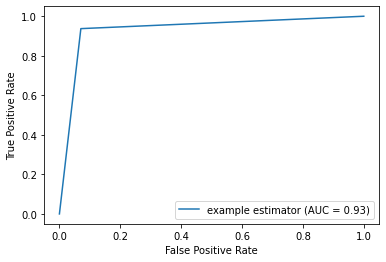

{'acc_in_fold_1': 0.9378603459320948}
{'acc_in_fold_2': 0.934657270980141}
{'acc_in_fold_3': 0.9692307692307692}
{'acc_in_fold_4': 0.9871794871794872}
{'acc_in_fold_5': 0.9769230769230769}
Cross Validation Score :  96.12%


{'model_name': 'Decision Tree',
 'acc': 93.33760409993593,
 'precision': 93.33287366737915,
 'recall': 93.34482815245416,
 'f1': 93.33639811515918}

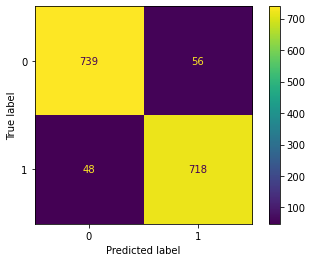

In [60]:
dtc = DecisionTreeClassifier()

res = fit_model('Decision Tree',dtc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Decision Tree',rf,X)
res

#### Hyperparameter Tuning

In [62]:
param_grid = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_depth': [4,6,8,12],
    'max_features': list((range(1,len(x_train.columns) + 1)))
}

dtcc = DecisionTreeClassifier()
rnd_search_cv = RandomizedSearchCV(dtcc, param_grid, n_iter=10, verbose=2)
#GridSearchCV(dtcc,param_grid,n_jobs=-1)
rnd_search_cv.fit(x_train,np.ravel(y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=12, max_features=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=12, max_features=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=12, max_features=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=12, max_features=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=12, max_features=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=1, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8, 12],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11],
                                        'splitter': ['best', 'random']},
                   verbose=2)

In [63]:
rnd_search_cv.best_params_

{'splitter': 'best',
 'max_features': 11,
 'max_depth': 8,
 'criterion': 'entropy'}

ROC_AUC Score :  86.02%


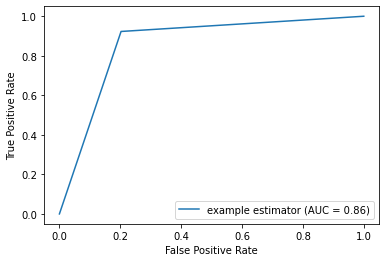

{'acc_in_fold_1': 0.7168481742472774}
{'acc_in_fold_2': 0.7572069186418963}
{'acc_in_fold_3': 0.8762820512820513}
{'acc_in_fold_4': 0.8173076923076923}
{'acc_in_fold_5': 0.8692307692307693}
Cross Validation Score :  80.74%


{'model_name': 'Decision Tree HT',
 'acc': 85.90647021140295,
 'precision': 86.46895219475866,
 'recall': 86.02303890175213,
 'f1': 85.8755807372896}

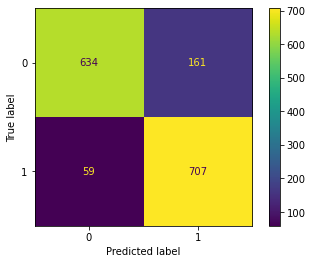

In [65]:
dtcc = DecisionTreeClassifier(splitter='best',max_features=11,max_depth=8,criterion='entropy')
#dtcc = DecisionTreeClassifier(splitter='best',max_features=5,max_depth=12,criterion='entropy')

res = fit_model('Decision Tree HT',dtcc,x_train,y_train,x_test,y_test)
# res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Decision Tree HT',dtcc,X)
res

## KNeighbors Classifier

ROC_AUC Score :  91.35%


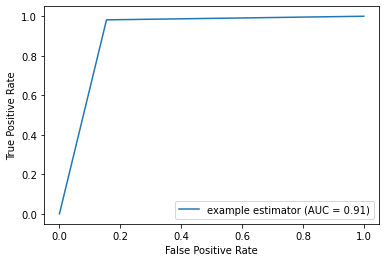

{'acc_in_fold_1': 0.8424087123638693}
{'acc_in_fold_2': 0.8385650224215246}
{'acc_in_fold_3': 0.9230769230769231}
{'acc_in_fold_4': 0.9634615384615385}
{'acc_in_fold_5': 0.9564102564102565}
Cross Validation Score :  90.48%


{'model_name': 'KNeighbors Classifier',
 'acc': 91.22357463164637,
 'precision': 91.95102040816326,
 'recall': 91.35031282329179,
 'f1': 91.20046281952054}

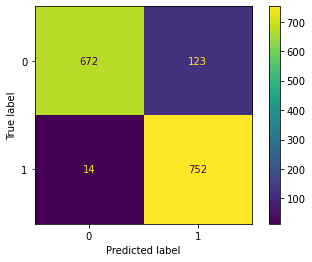

In [66]:
knn = KNeighborsClassifier(4)

res = fit_model('KNeighbors Classifier',knn,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('KNeighbors Classifier',knn,X)
res

#### Hyperparameter Tuning

In [67]:
param_grid = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

knnc = KNeighborsClassifier()
grid = GridSearchCV(knnc, param_grid, verbose = 1, cv=3, n_jobs = -1)
grid.fit(x_train,np.ravel(y_train))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [68]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

ROC_AUC Score :  91.43%


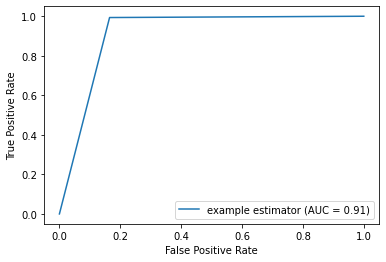

{'acc_in_fold_1': 0.8379244074311338}
{'acc_in_fold_2': 0.8360025624599615}
{'acc_in_fold_3': 0.9230769230769231}
{'acc_in_fold_4': 0.9961538461538462}
{'acc_in_fold_5': 0.985897435897436}
Cross Validation Score :  91.58%


{'model_name': 'KNeighbors Classifier HT',
 'acc': 91.28763613068546,
 'precision': 92.2832585949178,
 'recall': 91.43463553212803,
 'f1': 91.25386435695123}

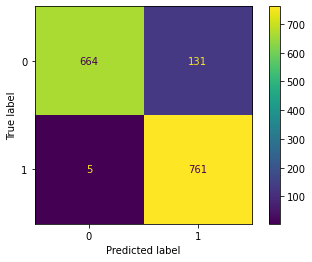

In [69]:
knnc = KNeighborsClassifier(metric='manhattan',n_neighbors=5, weights='distance')

res = fit_model('KNeighbors Classifier HT',knnc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('KNeighbors Classifier HT',knnc,X)
res

## Logistic regresion

ROC_AUC Score :  75.33%


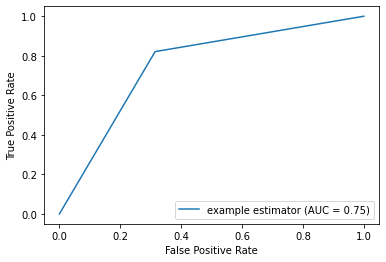

{'acc_in_fold_1': 0.6213965406790519}
{'acc_in_fold_2': 0.649583600256246}
{'acc_in_fold_3': 0.7647435897435897}
{'acc_in_fold_4': 0.7173076923076923}
{'acc_in_fold_5': 0.7173076923076923}
Cross Validation Score :  69.41%


{'model_name': 'Logistic Regression',
 'acc': 75.208199871877,
 'precision': 75.73530638322006,
 'recall': 75.33417081301214,
 'f1': 75.13620190437777}

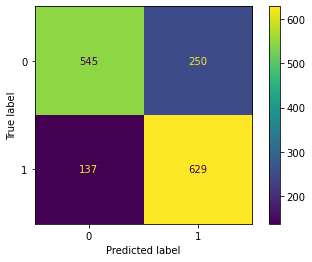

In [70]:
lr = LogisticRegression(random_state=42)

res = fit_model('Logistic Regression',lr,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Logistic Regression',lr,X)
res

#### Hyperparameter Tuning

In [43]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]


lrc = LogisticRegression()
grid = GridSearchCV(lrc, param_grid, verbose = 1, cv=3, n_jobs = -1)
grid.fit(x_train,np.ravel(y_train))
clear_ouput()

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


/Users/kristinazekiene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/kristinazekiene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/kristinazekiene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/kristinazekiene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/kristinazekiene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


NameError: name 'clear_ouput' is not defined

In [44]:
grid.best_params_

{'C': 0.0006951927961775605,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

ROC_AUC Score :  75.33%


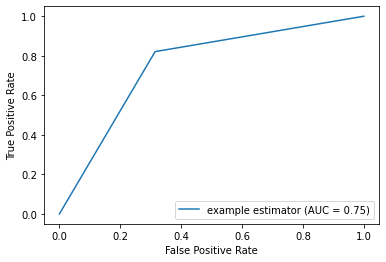

{'acc_in_fold_1': 0.6213965406790519}
{'acc_in_fold_2': 0.649583600256246}
{'acc_in_fold_3': 0.7647435897435897}
{'acc_in_fold_4': 0.7173076923076923}
{'acc_in_fold_5': 0.7173076923076923}
Cross Validation Score :  69.41%


{'model_name': 'Logistic Regression HT',
 'acc': 75.208199871877,
 'precision': 75.73530638322006,
 'recall': 75.33417081301214,
 'f1': 75.13620190437777}

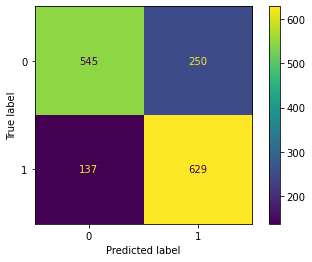

In [71]:
lrc = LogisticRegression(max_iter=100,penalty= 'l2',solver='liblinear')

res = fit_model('Logistic Regression HT',lrc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Logistic Regression HT',lrc,X)
res

## Support Vector Classifier

ROC_AUC Score :  85.52%


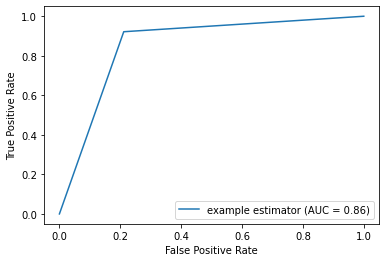

{'acc_in_fold_1': 0.7360666239590007}
{'acc_in_fold_2': 0.7277386290839206}
{'acc_in_fold_3': 0.8615384615384616}
{'acc_in_fold_4': 0.7987179487179488}
{'acc_in_fold_5': 0.8006410256410257}
Cross Validation Score :  78.49%


{'model_name': 'SVC',
 'acc': 85.39397821909033,
 'precision': 86.0222037912324,
 'recall': 85.51751317798907,
 'f1': 85.35647279549718}

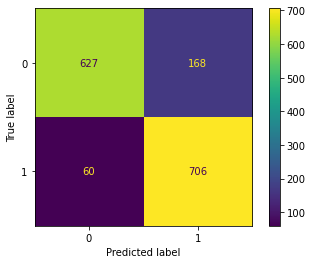

In [72]:
clf = SVC(probability=True)

res = fit_model('SVC',clf,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('SVC',clf,X)
res

#### Hyperparameter Tuning

In [74]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}


scvc = SVC(probability=True)
grid = GridSearchCV(scvc, param_grid, verbose = 1, cv=3, n_jobs = -1)
grid.fit(x_train,np.ravel(y_train))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=1)

In [75]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

ROC_AUC Score :  95.58%


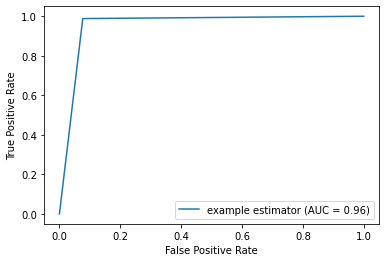

{'acc_in_fold_1': 0.9256886611146701}
{'acc_in_fold_2': 0.923126201153107}
{'acc_in_fold_3': 0.9532051282051283}
{'acc_in_fold_4': 0.9814102564102564}
{'acc_in_fold_5': 0.9673076923076923}
Cross Validation Score :  95.01%


{'model_name': 'SVC HT',
 'acc': 95.51569506726457,
 'precision': 95.665740883947,
 'recall': 95.57605464965432,
 'f1': 95.5147213355926}

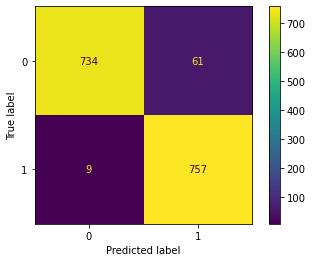

In [79]:
scvc = SVC(C=10, gamma=1,kernel='rbf',probability=True)

res = fit_model('SVC HT',scvc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('SVC HT',scvc,X)
res

## GradientBoostingClassifier

ROC_AUC Score :  92.95%


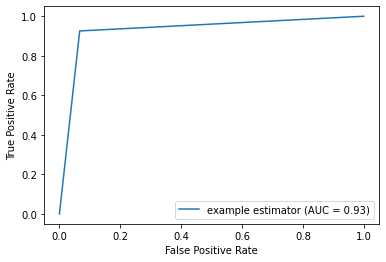

{'acc_in_fold_1': 0.8789237668161435}
{'acc_in_fold_2': 0.8680333119795003}
{'acc_in_fold_3': 0.9346153846153846}
{'acc_in_fold_4': 0.926923076923077}
{'acc_in_fold_5': 0.9211538461538461}
Cross Validation Score :  90.59%


{'model_name': 'Gradient Boosting Classifier',
 'acc': 92.95323510570147,
 'precision': 92.95535101291313,
 'recall': 92.94604003481288,
 'f1': 92.95008441340892}

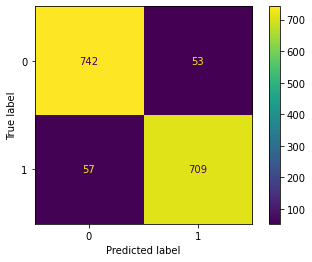

In [80]:
gbc = GradientBoostingClassifier()

res = fit_model('Gradient Boosting Classifier',gbc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('Gradient Boosting Classifier',gbc,X)
res

#### Hyperparameter Tuning

In [81]:
param_grid = {"n_estimators":[1,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

gbcc = GradientBoostingClassifier()
grid = GridSearchCV(gbcc, param_grid, verbose = 1, cv=3, n_jobs = -1)
grid.fit(x_train,np.ravel(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [1, 50, 250, 500]},
             verbose=1)

In [82]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}

ROC_AUC Score :  97.03%


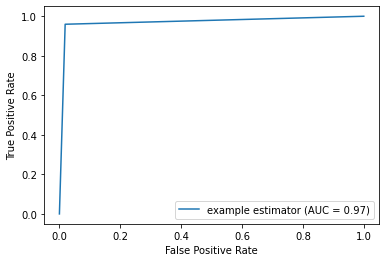

{'acc_in_fold_1': 0.9474695707879565}
{'acc_in_fold_2': 0.9417040358744395}
{'acc_in_fold_3': 0.9685897435897436}
{'acc_in_fold_4': 0.9897435897435898}
{'acc_in_fold_5': 0.985897435897436}
Cross Validation Score :  96.67%


{'model_name': 'GBC HT',
 'acc': 97.05317104420243,
 'precision': 97.08877928483354,
 'recall': 97.03310507906792,
 'f1': 97.05072008990034}

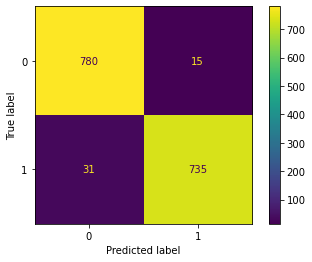

In [87]:
# gbcc = GradientBoostingClassifier(learning_rate=0.1,max_depth= 9,n_estimators= 250)
gbcc = GradientBoostingClassifier(learning_rate=0.1,max_depth= 9,n_estimators= 500)

res = fit_model('GBC HT',gbcc,x_train,y_train,x_test,y_test)
res_df = res_df.append(pd.DataFrame.from_dict(res,orient='index').T)
kfold_cross_validation('GBC HT',gbcc,X)
res

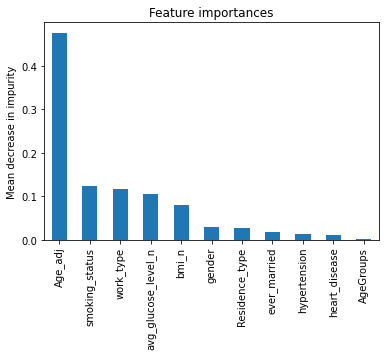

In [88]:
feature_importances = pd.Series(gbcc.feature_importances_, index=x_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

Gradient Boost classifier model gave the best results with accuracy = 97.05%.

The most important feature gaving most information to the model decision is age. Then smoking status, work type and avg. glocose level.

## XGBoost

In [89]:
xgbr = xgb.XGBRegressor(tree_method="hist", device="cuda")

my_model= xgbr.fit(x_train, y_train)

from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(x_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error: 0.12396287041377547


# Models quality comparison

Let's compare all tried ML models results

In [90]:
res_df = res_df.sort_values(by = 'acc', ascending = False)
res_df

,model_name,acc,precision,recall,f1
0,GBC HT,97.053171,97.088779,97.033105,97.05072
0,Random Forest,96.925048,96.923986,96.923986,96.923986
0,Random Forest other,96.732864,96.732847,96.730545,96.731656
0,Random Forest HT,95.771941,95.771365,95.787149,95.771551
0,SVC HT,95.515695,95.665741,95.576055,95.514721
0,Baseline,95.137202,95.137202,95.137202,95.137202
0,Decision Tree,93.337604,93.332874,93.344828,93.336398
0,Gradient Boosting Classifier,92.953235,92.955351,92.94604,92.950084
0,KNeighbors Classifier HT,91.287636,92.283259,91.434636,91.253864
0,KNeighbors Classifier,91.223575,91.95102,91.350313,91.200463


In [91]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
def hist_score(metric,dtf):
    models_names = list(dtf.model_name)

    plt.rcParams['figure.figsize']=20,8
    sns.set_style('darkgrid')
    ax = sns.barplot(x=models_names, y=dtf[metric], palette = "inferno", saturation =2.0)
    plt.xlabel('Classifier Models', fontsize = 20 )
    plt.ylabel(f'% of {metric}', fontsize = 20)
    plt.title(f'{metric} of different models on test set', fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    
    wrap_labels(ax, 10)
    ax.figure
    
    plt.show()

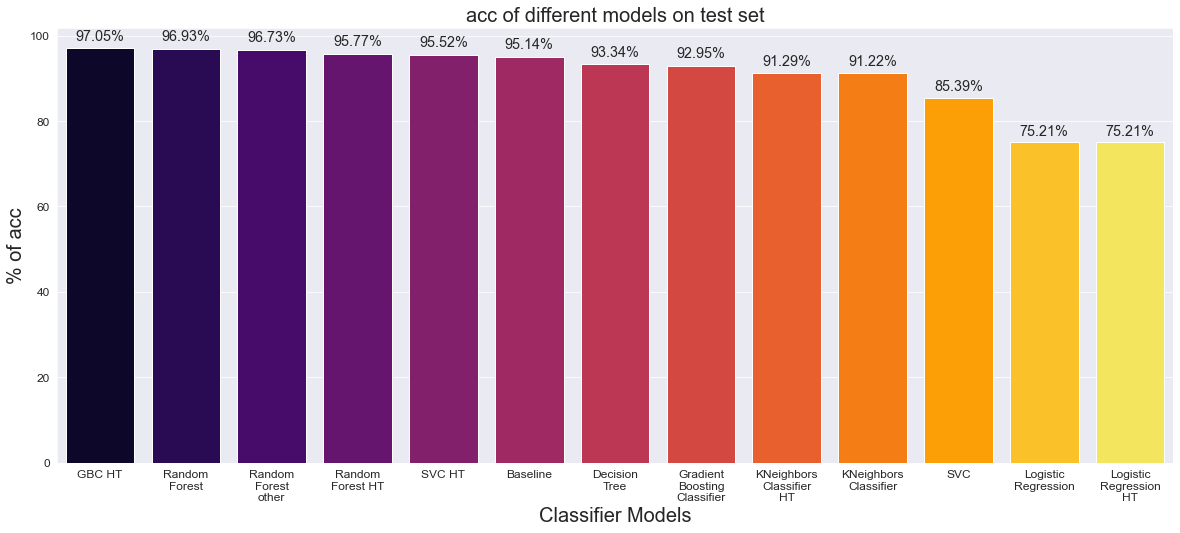

In [92]:
hist_score('acc',res_df)

<b>The best performed model was GradientBoost Classifier after hyperparameter tunning. Accuracy increased from 92.95% to 97.05%.<b>

The second best candidate model to predict patient probability to have a stroke is Random forest with default parameters configuration. Accuracy = 96.93%. 

Over all, Random forest variuos combinations performed better than basiline. 

SVC model performed a bit better than baseline, too.

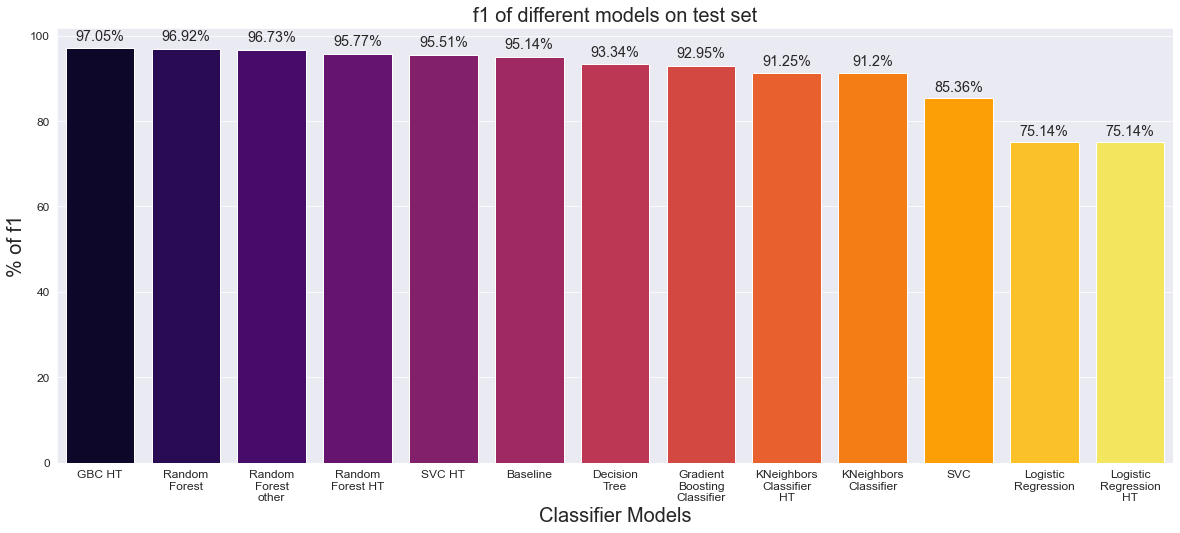

In [93]:
hist_score('f1',res_df)

The same was with F1 score. The best performed model was GradientBoost Classifier after hyperparameter tunning. F1 = 97.05%.

Random forest variuos combinations performed better than basiline. The best one was with default configuration.

# SHAP

We will apply SHAP technique to break down how our best performed model (Gradient Boost after hyperparameter tunning) works for an individual prediction, it shows the impact of each feature.

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [94]:
import shap  

explainer = shap.TreeExplainer(gbcc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x_test)

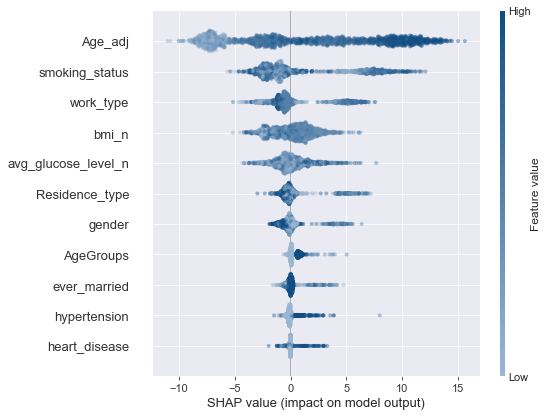

In [95]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

colors = ["#9bb7d4", "#0f4c81"]           
cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values, x_test,cmap=cmap,alpha=0.4)

The plot above shows the effext of each data point on our predictions.

For example, for age, the top left point reduced the prediction by ~7.4.

The color shows whether that feature was high or low for that row of the dataset Horizontal location shows whether the effect of that value caused a higher or lower prediction.

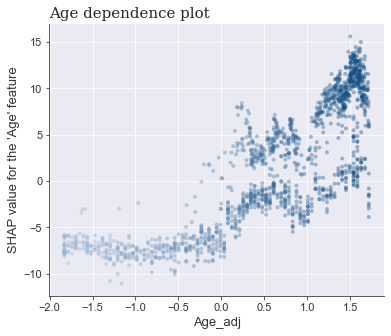

In [96]:
shap.dependence_plot('Age_adj', shap_values, x_test, interaction_index="Age_adj",cmap=cmap,alpha=0.4,show=False)
plt.title("Age dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'Age' feature")
plt.show()

Here we see a clear SHAP value increase for when strokes become far more common - the older age patient is.

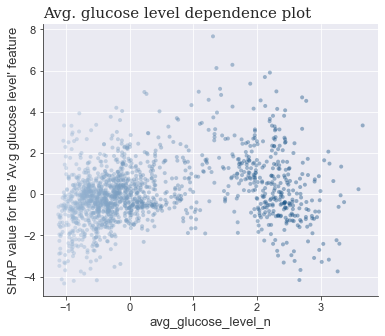

In [97]:
shap.dependence_plot('avg_glucose_level_n', shap_values, x_test, interaction_index="avg_glucose_level_n",cmap=cmap,alpha=0.4,show=False)
plt.title("Avg. glucose level dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'Av.g glucose level' feature")
plt.show()

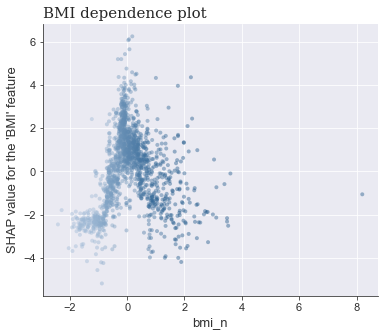

In [98]:
shap.dependence_plot('bmi_n', shap_values, x_test, interaction_index="bmi_n",cmap=cmap,alpha=0.4,show=False)
plt.title("BMI dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'BMI' feature")
plt.show()

Here we see a clear cutoff point for when strokes become far more common - after a BMI of around 0 or so.

# Conclusions

- The best performed model was GradientBoost Classifier after hyperparameter tunning. Accuracy increased from 92.95% to 97.05%.
- The second best candidate model to predict patient probability to have a stroke is Random forest with default parameters configuration. Accuracy = 96.93%.
- Over all, Random forest variuos combinations performed better than basiline.
- SVC model performed a bit better than baseline, too.
- We saw that age, smoking status, avg. glocose level and BMI are the most important features when it comes to predicting stroke-prone individuals, based on the current dataset.